In [6]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table 
from hugs import primitives as prim
import hugs
from time import time

from astropy.visualization import ZScaleInterval
from kuaizi.display import display_single, SEG_CMAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config_params = hugs.utils.read_config('../pipe-configs/hugs-config.yml')

patches = Table([[9813], '6,6', names=['tract', 'patch'])

patches['outdir'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/'
patches['log_fn'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/hugs-pipe.log'

patches['config_fn'] = '../pipe-configs/hugs-config.yml'
patches['run_name'] = 'hugs-pipe-run'

patches['rerun_path'] = None

tract, p1, p2 = patches['tract'], int(patches['patch'][:, 0]), int(patches['patch'][:, -1])
seed = [int(time())]
p = patches[0]

SyntaxError: invalid syntax (1288360567.py, line 3)

In [ ]:
config = hugs.PipeConfig(run_name=p['run_name'], 
                         config_fn=p['config_fn'],
                         random_state=seed[0], 
                         log_fn=p['log_fn'],
                         rerun_path=p['rerun_path'])

In [36]:
dataId = dict(tract=9813, patch='3,3', filter='HSC-I')
exp = config.butler.get(
    'deepCoadd_calexp', 
                  dataId)

In [37]:
mi = exp.getMaskedImage()
mask = exp.getMask()

In [38]:
img = exp.getImage().getArray()

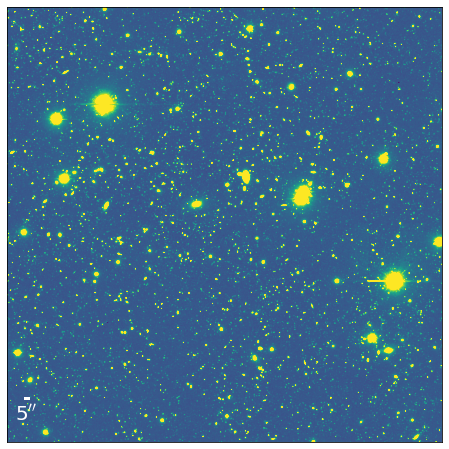

In [39]:
display_single(img);

In [40]:
psf_sigma = hugs.utils.get_psf_sigma(exp)
# mi_smooth = mi
mi_smooth = hugs.imtools.smooth_gauss(mi, psf_sigma, use_scipy=True)

In [41]:
fpset_low = prim.image_threshold(mi_smooth, 
                                 thresh=3.0,
                                 mask=mask, 
                                 plane_name='THRESH_LOW',
                                 rgrow=4)

fpset_high = prim.image_threshold(mi_smooth, 
                                 thresh=28.0,
                                 mask=mask, 
                                 plane_name='THRESH_HIGH',
                                 rgrow=15)

In [42]:
# seg_high = get_fp_array(fpset_high)

In [27]:
seg_high = fpset_high.insertIntoImage().getArray().copy()
seg_high = seg_high.astype(float)
seg_high[seg_high > 0.0] = 1.0

seg_low = fpset_low.insertIntoImage().getArray().copy()
seg_low = seg_low.astype(float)
seg_low[seg_low > 0.0] = 1.0

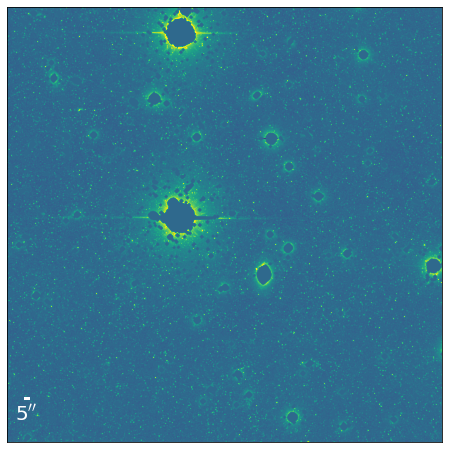

In [30]:
display_single(img * ~(seg_high.astype(bool)));

In [47]:
exp_clean = prim.clean(exp, fpset_low, rgrow=10, max_frac_high_thresh=0.15)

In [44]:
def show_step(img, ax, vmin, vmax, title, seg=None, alpha=0.6, cmap=plt.cm.gnuplot):
    
    ax.imshow(img, cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
    
    if seg is not None:
        if type(seg) is not list:
            seg = [seg]
        if type(alpha) is not list:    
            alpha = [alpha]*len(seg)  
        for s, a in zip(seg, alpha): 
            ax.imshow(s, alpha=a, cmap=cmap, vmin=0, vmax=1, origin='lower')
            
    ax.set_title(title, fontsize=15)
            
def get_fp_array(fpset):
    seg = fpset.insertIntoImage().getArray().copy()
    seg = seg.astype(float)
    seg[seg==0] = np.nan
    seg[~np.isnan(seg)] = 1.0
    return seg

zscale = ZScaleInterval()

In [48]:
img = exp.getImage().getArray()
img_clean = exp_clean.getImage().getArray()
seg_high = get_fp_array(fpset_high)
seg_low = get_fp_array(fpset_low)
vmin, vmax = zscale.get_limits(img)

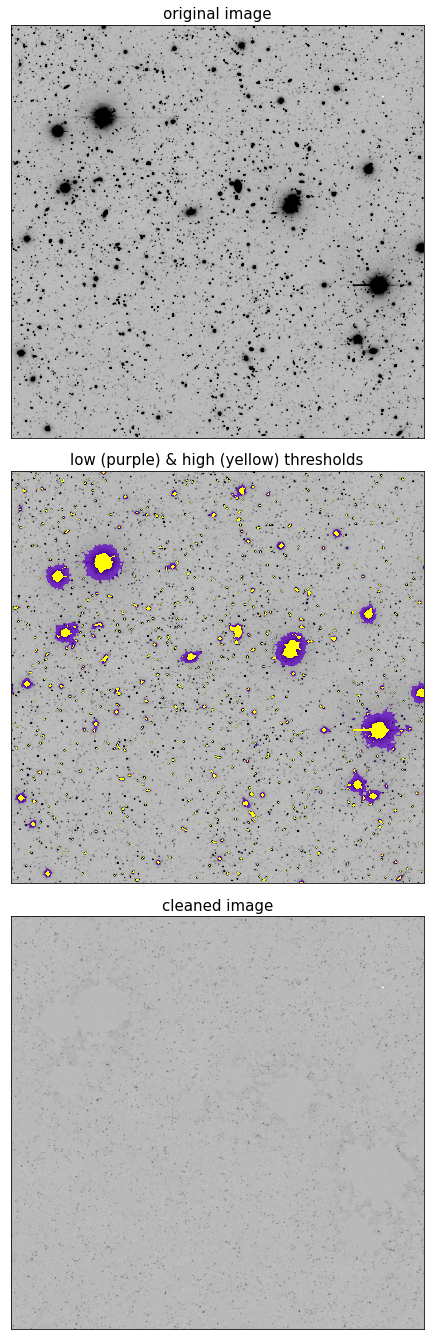

In [49]:
fig, axes = plt.subplots(3, 1, figsize=(8, 24), 
                         subplot_kw=dict(xticks=[], yticks=[], aspect='equal'))
fig.subplots_adjust(hspace=0.08)
show_step(img, axes[0], vmin, vmax, 'original image')
show_step(img, axes[1], vmin, vmax, 'low (purple) & high (yellow) thresholds', 
          [seg_low*0.15, seg_high*1], [0.7, 1])
show_step(img_clean, axes[2], vmin, vmax, 'cleaned image')

In [ ]:
config_params = hugs.utils.read_config('../pipe-configs/hugs-config.yml')

patches = Table([[9813], ['6,6']], names=['tract', 'patch'])

patches['outdir'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/'
patches['log_fn'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/hugs-pipe.log'

patches['config_fn'] = '../pipe-configs/hugs-config.yml'
patches['run_name'] = 'hugs-pipe-run'

patches['rerun_path'] = None

tract, p1, p2 = patches['tract'], int(patches['patch'][0][0]), int(patches['patch'][0][-1])
seed = [int(time())]
p = patches[0]

In [ ]:
config = hugs.PipeConfig(run_name=p['run_name'], 
                         config_fn=p['config_fn'],
                         random_state=seed[0], 
                         log_fn=p['log_fn'],
                         rerun_path=p['rerun_path'])

In [ ]:
config.set_patch_id(p['tract'], p['patch'])

In [7]:
from hugs.pipeline import next_gen_search

In [ ]:
exp_clean, cfg = next_gen_search.run(config, False)

In [ ]:
img_clean = exp_clean.getImage().getArray()

In [ ]:
if config.hsc_small_sources_r_max is not None:
    if config.hsc_small_sources_r_max > 0:
        config.logger.info('removed small sources with HSC detection map')
        exp_clean = prim.remove_small_sources_thresholding(
            exp_clean, config.hsc_small_sources_r_max, config.rng)

mi_clean = exp_clean.getMaskedImage()
mask_clean = mi_clean.getMask()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_clean - mi_clean.image.array, vmin=0, vmax=0.1)

In [ ]:
from hugs.sep_stepper import SepLsstStepper, sep_ellipse_mask

In [ ]:
############################################################
# use sep to find and mask point-like sources
############################################################

sep_stepper = SepLsstStepper(config=config.sep_steps)
sep_stepper.setup_image(exp_clean, config.rng)

step_mask = config.exp.get_mask_array(
    planes=['BRIGHT_OBJECT', 'NO_DATA', 'SAT'])
sep_sources, _ = sep_stepper.run('sep_point_sources',
                                 mask=step_mask)

config.logger.info('generating and applying sep ellipse mask')
r_min = config.sep_min_radius
sep_sources = sep_sources[sep_sources['flux_radius'] < r_min]
ell_msk = sep_ellipse_mask(
    sep_sources, sep_stepper.image.shape, config.sep_mask_grow)
nimage_replace = sep_stepper.noise_image[ell_msk]
mi_clean.getImage().getArray()[ell_msk] = nimage_replace
mask_clean.addMaskPlane('SMALL')
mask_clean.getArray()[
    ell_msk] += mask_clean.getPlaneBitMask('SMALL')

In [ ]:
############################################################
# Detect sources and measure props with SExtractor
############################################################

config.logger.info('detecting in {}-band'.format(config.band_detect))
label = '{}-{}-{}'.format(config.tract, config.patch[0], config.patch[-1])

config.logger.info('cleaning non-detection bands')
replace = config.exp.get_mask_array(config.band_detect)
for band in config.bands:
    if band != config.band_detect:
        print(band)
        mi_band = config.exp[band].getMaskedImage()
        noise_array = hugs.utils.make_noise_image(mi_band, config.rng)
        mi_band.getImage().getArray()[replace] = noise_array[replace]

so g-band has been cleaned. other bands are not. 

Then we detect in g-band, do forced photometry on r- and i-bands using g-band detections. 

We do another round of detection on the uncleaned r-band, and cross-match with g-band detection catalog. We take the intersection of the two catalogs.

In [ ]:
from astropy.table import hstack

In [ ]:
sources = Table()

for band in cfg.bands:
    cfg.logger.info('measuring in {}-band'.format(band))
    dual_exp = None if band == cfg.band_detect else cfg.exp[band]
    sources_band = prim.detect_sources(
        exp_clean, cfg.sex_config, cfg.sex_io_dir, label=label,
        dual_exp=dual_exp,
        delete_created_files=cfg.delete_created_files,
        original_fn=cfg.exp.fn[cfg.band_detect])
    if len(sources_band) > 0:
        sources = hstack([sources, sources_band])
    else:
        cfg.logger.warn('**** no sources found by sextractor ****')
        results = _null_return(cfg, exp_clean)

In [ ]:
############################################################
# Verify detections in other bands using SExtractor
############################################################

all_detections = sources.copy()

for band in config.band_verify:
    config.logger.info('verifying dection in {}-band'.format(band))
    sources_verify = prim.detect_sources(
        config.exp[band], config.sex_config, config.sex_io_dir,
        label=label, delete_created_files=config.delete_created_files,
        original_fn=config.exp.fn[band])
    if len(sources_verify) > 0:
        match_masks, _ = hugs.cattools.xmatch(
            sources, sources_verify, max_sep=config.verify_max_sep)
        txt = 'cuts: {} out of {} objects detected in {}-band'.format(
            len(match_masks[0]), len(sources), band)
        config.logger.info(txt)
        if len(match_masks[0]) == 0:
            config.logger.warn(
                '**** no matched sources with ' + band + ' ****')
            results = _null_return(config, exp_clean)

        sources = sources[match_masks[0]]
    else:
        config.logger.warn(
            '**** no sources detected in ' + band + ' ****')
        results = _null_return(config, exp_clean)

### Just take Johnny's

In [42]:
config_params = hugs.utils.read_config('../pipe-configs/hugs-config.yml')

patches = Table([[9813], ['6,6']], names=['tract', 'patch'])

patches['outdir'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/'
patches['log_fn'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/hugs-pipe.log'

patches['config_fn'] = '../pipe-configs/hugs-config.yml'
patches['run_name'] = 'hugs-pipe-run'

patches['rerun_path'] = None

tract, p1, p2 = patches['tract'], int(patches['patch'][0][0]), int(patches['patch'][0][-1])
seed = [int(time())]
p = patches[0]

In [43]:
config = hugs.PipeConfig(run_name=p['run_name'], 
                         config_fn=p['config_fn'],
                         random_state=seed[0], 
                         log_fn=p['log_fn'],
                         rerun_path=p['rerun_path'])

In [44]:
config.set_patch_id(p['tract'], p['patch'])
results = next_gen_search.run(config, False)

INFO: starting hugs: 9813 | 6,6


INFO: growing clean footprints with rgrow = 20.0
INFO: making mask using i-band
INFO: good data fraction = 1.00
INFO: thresh type set to SB
INFO: performing low threshold at 5.97 sigma
INFO: performing high threshold at 59.66 sigma
INFO: generating cleaned exposure
INFO: removed small sources with HSC detection map
INFO: running sep_point_sources
INFO: applying mask
INFO: smoothing with kernel with fwhm = 0.78 arcsec
INFO: detecting with a threshold of 1.5 x background
INFO: found 3317 sources
INFO: measuring source parameters
INFO: generating and applying sep ellipse mask
INFO: building ellipse mask
INFO: 3.15% of patch masked
INFO: detecting in g-band
INFO: cleaning non-detection bands
INFO: measuring in r-band

running 
-------
sex -c /home/jiaxuanl/Research/Packages/hugs/hugs/sextractor/config/hugs-default.sex /scratch/gpfs/jiaxuanl/Data/HSC/sextractor-io/exp-9813-6-6-g.fits[1],/scratch/gpfs/jiaxuanl/Data/HSC/sextractor-io/exp-9813-6-6-r.fits[1] -CATALOG_NAME /scratch/gpfs/jiaxuanl

In [45]:
pm = results.hugs_exp.patch_meta
patch_meta = hugs.utils.PatchMeta(
    x0 = pm.x0,
    y0 = pm.y0,
    small_frac = pm.small_frac,
    cleaned_frac = pm.cleaned_frac,
    bright_obj_frac = pm.bright_obj_frac,
    good_data_frac = pm.good_data_frac
)

meta_data = [
    config.run_name,
    config.tract,
    config.patch,
    patch_meta,
]

if results.success:
    df = results.sources.to_pandas()
    df['flags'] = df['flags'].astype(int)
else:
    df = None
    
obj_cat = Table.from_pandas(df)

In [46]:
from kuaizi.display import draw_circles

### Compare with the catalog from Johnny

In [47]:
bbox = config.exp['i'].getBBox()

greco_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/Greco_S18A_lsbg.fits')

low_coord = config.exp['i'].wcs.pixelToSky(bbox.minX, bbox.minY)
hi_coord = config.exp['i'].wcs.pixelToSky(bbox.endX, bbox.endY)

flag = (greco_cat['ra'] > float(hi_coord.getRa().asDegrees())
) & (greco_cat['ra'] < float(low_coord.getRa().asDegrees())
    ) & (greco_cat['dec'] > float(low_coord.getDec().asDegrees())
        ) & (greco_cat['dec'] < float(hi_coord.getDec().asDegrees()))

temp = greco_cat[flag]

temp['x_image'], temp['y_image'] = config.exp['i'].wcs.skyToPixelArray(temp['ra'], temp['dec'], degrees=True)

temp['x_image'] -= bbox.minX
temp['y_image'] -= bbox.minY

In [50]:
# Crude cuts

obj_cat['A_gi'] = obj_cat['A_g'] - obj_cat['A_i']
obj_cat['A_gr'] = obj_cat['A_g'] - obj_cat['A_r']

obj_cat['gi'] = obj_cat['mag_ap6_g'] - obj_cat['mag_ap6_i'] - obj_cat['A_gi']
obj_cat['gr'] = obj_cat['mag_ap6_g'] - obj_cat['mag_ap6_r'] - obj_cat['A_gr']

flag = (obj_cat['flux_radius_50_g'] > 2.0)# & (obj_cat['flux_radius_50_g'] < 20.0) 
flag &= (obj_cat['gi'] > -0.1) & (obj_cat['gi'] < 1.4)
flag &= (obj_cat['gr'] > 0.7 * obj_cat['gi'] - 0.4) & (obj_cat['gr'] < 0.7 * obj_cat['gi'] + 0.4)
print('Num of objects:', np.sum(flag))

Num of objects: 19


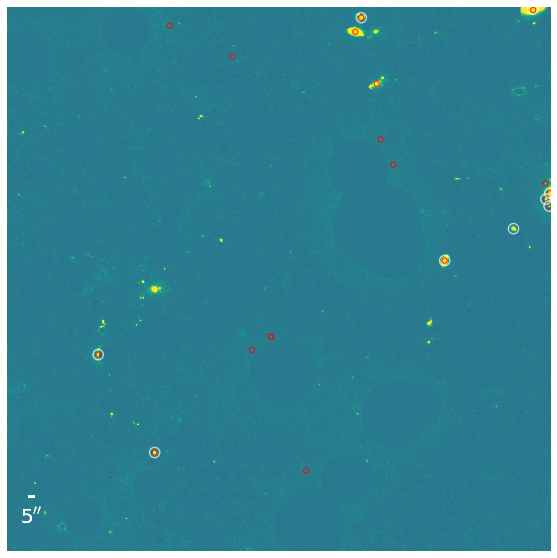

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = draw_circles(config.mi_clean.getImage().array, 
             obj_cat[flag], colnames=['x_image', 'y_image'], 
             circle_size=40, ax=ax)

ax = draw_circles(config.mi_clean.getImage().array, 
             temp, 
             colnames=['x_image', 'y_image'],
             circle_size=80,
             color='w', ax=ax)

In [52]:
from astropy.cosmology import Planck15
apparent_mag = abs_mag + Planck15.distmod(0.3)

<Quantity 41.02246626 mag>

In [358]:
img = config.exp['g'].getImage().array

In [379]:
obj = temp[11]#obj_cat[flag][21]
half_width = 70

In [380]:
img_cut = img[int(obj['y_image'])-half_width:int(obj['y_image'])+half_width, 
    int(obj['x_image'])-half_width:int(obj['x_image'])+half_width]

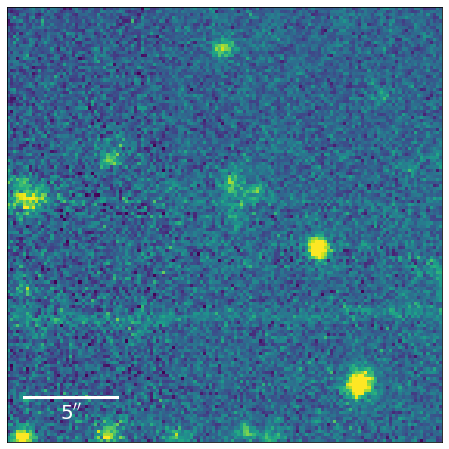

In [381]:
display_single(img_cut);

In [17]:
np.sum(flag)

44